In [18]:
from astropy.io import fits
from astropy.table import unique, vstack
from astropy.table import Table
from astropy.time import Time
from astroquery.mast import Mast,Observations
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
import jwst

In [3]:
jwst.__version__

'1.8.2'

In [4]:
def set_params(parameters):
    return [{"paramName" : p, "values" : v} for p, v in parameters.items()]

def set_mjd_range(min, max):
    '''Set time range in MJD given limits expressed as ISO-8601 dates'''
    return {
        "min": Time(min, format='isot').mjd, 
        "max": Time(max, format='isot').mjd
        }

# I : Keyword Search

In [5]:
service = 'Mast.Jwst.Filtered.Nircam'

keywords = {
            'exp_type':['NRC_CORON'],
            'instrume':['NIRCAM'],
            'date_obs_mjd': [set_mjd_range('2022-01-01','2022-10-27')],
           }

params = {'columns': '*',
          'filters': set_params(keywords)
         }



In [7]:
t = Mast.service_request(service, params)
display_columns = [x for x in t.colnames]

In [8]:
t[display_columns]

ArchiveFileID,filename,fileSetName,productLevel,act_id,apername,asnpool,asntable,bartdelt,bendtime,bkgdtarg,bkglevel,bkgsub,bmidtime,bstrtime,category,cont_id,datamode,dataprob,date,date_mjd,date_end,date_end_mjd,date_obs,date_obs_mjd,detector,drpfrms1,drpfrms3,duration,effexptm,effinttm,eng_qual,exp_type,expcount,expend,expmid,exposure,expripar,expstart,fastaxis,filter,frmdivsr,gainfact,gdstarid,groupgap,gs_dec,gs_mag,gs_order,gs_ra,gsendtim,gsendtim_mjd,gsstrttm,gsstrttm_mjd,gs_udec,gs_umag,gs_ura,helidelt,hendtime,hga_move,hmidtime,hstrtime,instrume,intarget,is_psf,lamp,mu_dec,mu_epoch,mu_epoch_mjd,mu_ra,nexposur,nextend,nframes,ngroups,nints,nresets,nrststrt,nsamples,numdthpt,nwfsest,obs_id,observtn,obslabel,origin,pcs_mode,pi_name,pps_aper,prd_ver,program,prop_dec,prop_ra,pwfseet,readpatt,sca_num,scicat,sdp_ver,selfref,seq_id,slowaxis,subarray,subcat,subsize1,subsize2,substrt1,substrt2,targ_dec,targ_ra,targname,targoopp,targprop,targtype,targudec,targura,telescop,template,tframe,tgroup,timesys,title,tsample,tsovisit,visit,visit_id,visitend,visitend_mjd,visitgrp,visitsta,visitype,vststart,vststart_mjd,xoffset,yoffset,zerofram,errtype,rois,roiw,wpower,wtype,datamodl,exp_only,exsegnum,exsegtot,intstart,intend,date_beg,date_beg_mjd,obsfoldr,sctarate,opmode,osf_file,expsteng,expsteng_mjd,masterbg,scatfile,srctyapt,tcatfile,texptime,patt_num,pattsize,patttype,pridtpts,subpxpts,crowdfld,engqlptg,oss_ver,noutputs,gs_v3_pa,dirimage,pixfrac,pxsclrt,segmfile,va_dec,va_ra,compress,bkgmeth,s_region,cal_ver,cal_vcs,crds_ctx,crds_ver,channel,coronmsk,fa1value,fa2value,fa3value,fam_la1,fam_la2,fam_la3,faphase1,faphase2,faphase3,fastep1,fastep2,fastep3,faunit1,faunit2,faunit3,module,pilin,pupil,subpxpat,pridtype,smgrdpat,fileSize,checksum,ingestStartDate,ingestStartDate_mjd,ingestCompletionDate,ingestCompletionDate_mjd,FileTypeID,publicReleaseDate,publicReleaseDate_mjd,isRestricted,isItar,isStale,FileSetId,dataURI
str8,str65,str25,str2,str2,str24,str32,str49,float64,float64,str1,float64,str1,float64,float64,str3,int64,int64,str1,str21,float64,str21,float64,str21,float64,str8,int64,int64,float64,float64,float64,str2,str9,int64,float64,float64,int64,str5,float64,int64,str6,int64,float64,str10,int64,float64,float64,int64,float64,str21,float64,str21,float64,float64,float64,float64,float64,float64,str1,float64,float64,str6,str1,str1,str1,float64,str21,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,str26,int64,str54,str5,str9,str20,str24,str13,int64,float64,float64,float64,str8,int64,str28,str7,str1,str1,int64,str11,str6,int64,int64,int64,int64,float64,float64,str30,str1,str25,str5,float64,float64,str4,str28,float64,float64,str3,str75,float64,str1,int64,str11,str21,float64,str2,str10,str20,str21,float64,float64,float64,str1,str1,float64,float64,float64,str1,str16,str1,int64,int64,int64,int64,str21,float64,str45,float64,str1,str29,str1,float64,str1,str1,str1,str1,float64,int64,str1,str4,int64,int64,str1,str26,str15,int64,float64,str1,float64,float64,str1,float64,float64,str1,str1,str125,str5,str7,str14,str8,str5,str9,int64,int64,int64,int64,int64,int64,str4,str4,str4,int64,int64,int64,float64,float64,float64,str1,str1,str7,str17,str1,str14,str10,str32,str21,float64,str21,float64,int64,str21,float64,bool,bool,bool,str7,str83
7432215,jw01386-c1018_t001_nircam_f250m-maskrnd-sub320a335r_i2d.fits,jw01386-c1018_t001_nircam,3,06,NRCA5_MASK335R,jw01386_20220705t224004_pool.csv,jw01386-c1018_20220705t224004_coron3_005_asn.json,-98.01271897740662,59790.09260348617,f,nan,--,59790.08545203265,59790.07830057918,ERS,--,25,f,/Date(1659172737546)/,59790.38816604167,/Date(1659154543850)/,59790.17759085648,/Date(1659146063182)/,59790.07943498842,NRCALONG,0,0,2471.784,2463.068,307.88352,OK,NRC_CORON,4,59790.17759085648,59790.12851292106,1,PRIME,59790.07943498565,-1,F250M,8,nan,S95S060319,12,-51.51151394558011,14.70571517944336,1,201.0210931102054,/Date(1659145052787)/,59790.06774057871,/Date(1659144811123)/,59790.06494355324,0.000100

# II: Construct the Observation Search

In [9]:
fn = list(set(t['filename']))

ids = list(set(['_'.join(x.split('_')[:-1]) for x in fn]))

In [10]:
matched_obs = Observations.query_criteria(instrument_name='Nircam',
                                          obs_id=ids,
                                         )

In [11]:
display_cols = [x for x in matched_obs.columns]
matched_obs[display_cols]

dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID
str5,int64,str4,str51,str30,float64,float64,float64,float64,float64,str8,str6,float64,float64,str1,str75,float64,str6,str20,str4,str3,str4,int64,str7,str1214,str82,str78,str16,bool,float64,str7,str8,str9
image,2,JWST,jw01537027001_03105_00003_nrcalong,G 191-B2B OFFSET,76.37757625,52.83247777777778,59831.30781003472,59831.30842869213,53.472,Infrared,F300M,2829.0,3155.0,--,Absolute Flux Calibration (White Dwarfs),59831.40502313,NIRCAM,"Gordon, Karl D.",1537,CAL,JWST,--,CALJWST,POLYGON 76.382987996 52.830609605 76.373710519 52.830263323 76.373217083 52.835796753 76.382474986 52.836150507,mast:JWST/product/jw01537027001_03105_00003_nrcalong_calints.jpg,mast:JWST/product/jw01537027001_03105_00003_nrcalong_rateints.fits,PUBLIC,False,nan,science,91714766,185868860
image,2,JWST,jw01536065001_0310d_00003_nrcalong,2MASS J17430448+6655015 OFFSET,265.7686904166666,66.91851666666668,59825.37895228658,59825.38249100695,305.786,Infrared,F430M,4167.0,4398.0,--,Absolute Flux Calibration (A Dwarfs),59825.87343743,NIRCAM,"Gordon, Karl D.",1536,CAL,JWST,--,CALJWST,POLYGON 265.76298885 66.921857506 265.776747735 66.920294315 265.772704616 66.914984909 265.75897218 66.916536528,mast:JWST/product/jw01536065001_0310d_00003_nrcalong_calints.jpg,mast:JWST/product/jw01536065001_0310d_00003_nrcalong_rateints.fits,PUBLIC,False,nan,science,90862588,185822591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
image,2,JWST,jw01075226001_03105_00005_nrcalong,HD 147980,245.9818520833333,28.38403888888889,59757.75170857095,59757.75307552084,107.368,Infrared,F335M,3177.0,3538.0,--,NIRCam Target Acquisition for Coronagraphy,59774.8541666,NIRCAM,"Girard, Julien",1075,COM,JWST,--,CALJWST,POLYGON 245.970314296 28.412481675 245.992051098 28.382000902 245.958118161 28.36310681 245.936056776 28.393057191,mast:JWST/product/jw01075226001_03105_00005_nrcalong_calints.jpg,mast:JWST/product/jw01075226001_03105_00005_nrcalong_rateints.fits,PUBLIC,False,nan,science,87482481,183078872
image,2,JWST,jw01536065001_0310l_00003_nrcalong,2MASS J17430448+6655015 OFFSET,265.7686904166666,66.91851666666668,59825.41878194444,59825.41940060185,53.472,Infrared,F356W,3140.0,3980.0,--,Absolute Flux Calibration (A Dwarfs),59825.87373831,NIRCAM,"Gordon, Karl D.",1536,CAL,JWST,--,CALJWST,POLYGON 265.762726401 66.921503367 265.776485105 66.919940201 265.772442108 66.914630788 265.758709853 66.916182382,mast:JWST/product/jw01536065001_0310l_00003_nrcalong_calints.jpg,mast:JWST/product/jw01536065001_0310l_00003_nrcalong_rateints.fits,PUBLIC,False,nan,science,90862602,185822820


In [12]:
print(f'Found {len(matched_obs)} matching Observations.')

Found 948 matching Observations.


In [13]:
matched_obs[display_cols]
batch_size = 5
batches = [matched_obs[i:i+batch_size] for i in range(0, len(matched_obs), batch_size)]
t = [Observations.get_product_list(obs) for obs in batches]
products = unique(vstack(t), keys='productFilename')
print(f'  Number of unique products: {len(products)}')

  Number of unique products: 16705


In [14]:
filtered_products = Observations.filter_products(products,
                                                 #dataproduct_type='image',
                                                 #productType = ['SCIENCE'],
                                                 #proposal_id = ['1075'],
                                                 productSubGroupDescription = ['RATEINTS',
                                                                               #'PSFSTACK',
                                                                               #'CALINTS',
                                                                               #'CRFINTS',
                                                                               #'PSFALIGN',
                                                                               'POOL',
                                                                               'ASN'])

In [15]:
filtered_products

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str8,str4,str5,str51,str64,str1,str83,str9,str28,str14,str1,str7,str5,str4,str65,int64,str8,str16,int64
83255951,JWST,image,jw01075001001_03105_00009_nrca4,source/target (L3) : association generator,S,mast:JWST/product/jw01075-o001_20221014t190114_image2_001_asn.json,INFO,Minimum Recommended Products,ASN,--,CALJWST,1.4.6,1075,jw01075-o001_20221014t190114_image2_001_asn.json,1881,83255951,PUBLIC,2
83255990,JWST,image,jw01075001001_03105_00009_nrca2,source/target (L3) : association generator,S,mast:JWST/product/jw01075-o001_20221014t190114_image2_002_asn.json,INFO,Minimum Recommended Products,ASN,--,CALJWST,1.4.6,1075,jw01075-o001_20221014t190114_image2_002_asn.json,1881,83255990,PUBLIC,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89378071,JWST,image,jw01538052001_0310n_00005_nrcalong,exposure (L2a): 3D countrate per integration,S,mast:JWST/product/jw01538052001_0310n_00005_nrcalong_rateints.fits,SCIENCE,Minimum Recommended Products,RATEINTS,--,CALJWST,1.6.2,1538,jw01538052001_0310n_00005_nrcalong_rateints.fits,2119680,89378071,PUBLIC,2
89378089,JWST,image,jw01538052001_0310l_00002_nrcalong,source/target (L3) : association pool,S,mast:JWST/product/jw01538_20221017t055317_pool.csv,INFO,Minimum Recommended Products,POOL,--,CALJWST,1.6.2,1538,jw01538_20221017t055317_pool.csv,1101077,89378089,PUBLIC,2


In [25]:
def determine_and_count(column:str):    
    prop_list = []
    counter = {}
    for i in range(len(filtered_products['proposal_id'])):

        if filtered_products[f'{column}'][i] not in prop_list:

            prop_list.append(filtered_products[f'{column}'][i])
            counter[filtered_products[f'{column}'][i]] = 1
        else:

            counter[filtered_products[f'{column}'][i]] += 1
            
    print(prop_list)
    print(counter)

In [26]:
determine_and_count('productSubGroupDescription')

['ASN', 'RATEINTS', 'POOL']
{'ASN': 937, 'RATEINTS': 1155, 'POOL': 13}


In [27]:
def get_json_rateints_table(table):
    
    testing_df = table.to_pandas()
    rateints_files = testing_df.loc[testing_df['productSubGroupDescription'] == 'RATEINTS']['obs_id']
    obs_ids = []
    for i in rateints_files:
        obs_ids.append(i)
        
    rateints_df = testing_df.loc[testing_df['obs_id'].isin(obs_ids)]
    info_files = rateints_df.loc[rateints_df['productType']=='INFO']
    info_table = Table.from_pandas(info_files)
    
    return info_files

# Downloading the Products

In [45]:
Observations.login('810c938e63be45d1be03ae3591999c5d')

INFO: MAST API token accepted, welcome Sarper Yurtseven [astroquery.mast.auth]


In [46]:
coron_files = Observations.download_products(info_table,download_dir = '/home/sarperyn/sarperyurtseven/ProjectFiles/CoronFiles/')

In [47]:
import glob
import json
import os

In [48]:
path = '/home/sarperyn/sarperyurtseven/ProjectFiles/CoronFiles/mastDownload/JWST/'
coron_exptype = []
noncoron_exptype = []

for i in glob.glob(f'{path}/**/*.json'):
    
    with open(i,'r') as f:
        asn_file = json.load(f)
        
        fits_name = asn_file['products'][0]['members'][0]['expname']
        if 'nrc_coron' in asn_file['constraints']:
            #print('There is a coron right here')
            
            coron_exptype.append(fits_name)
            
        else:
            noncoron_exptype.append(fits_name)

In [50]:
len(coron_exptype)

846

In [51]:
len(noncoron_exptype)

60

# Some Visualizations

In [230]:
coron_files

Local Path,Status,Message,URL
str130,str8,object,object
CoronFiles/mastDownload/JWST/jw01075001001_03105_00009_nrca4/jw01075-o001_20221014t190114_image2_001_asn.json,COMPLETE,None,None
CoronFiles/mastDownload/JWST/jw01075001001_03105_00009_nrca2/jw01075-o001_20221014t190114_image2_002_asn.json,COMPLETE,None,None
CoronFiles/mastDownload/JWST/jw01075001001_03105_00007_nrca2/jw01075-o001_20221014t190114_image2_003_asn.json,COMPLETE,None,None
CoronFiles/mastDownload/JWST/jw01075001001_03105_00007_nrca4/jw01075-o001_20221014t190114_image2_004_asn.json,COMPLETE,None,None
CoronFiles/mastDownload/JWST/jw01075001001_03105_00008_nrca3/jw01075-o001_20221014t190114_image2_005_asn.json,COMPLETE,None,None
CoronFiles/mastDownload/JWST/jw01075001001_03105_00005_nrca1/jw01075-o001_20221014t190114_image2_006_asn.json,COMPLETE,None,None
...,...,...,...
CoronFiles/mastDownload/JWST/jw01538052001_03103_00002_nrcalong/jw01538-o052_20221017t055317_image2_051_asn.json,COMPLETE,None,None
CoronFiles/mastDownload/JWST/jw01538052001_0310l_00005_nrcalong/jw01538-o052_20221017t055317_image2_052_asn.json,COMPLETE,None,None


In [26]:
coron10751_ = fits.open(coron_files['Local Path'][0])

In [28]:
coron10751_.info()

Filename: CoronFiles/mastDownload/JWST/jw01075001001_03105_00001_nrca1/jw01075001001_03105_00001_nrca1_rateints.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     263   ()      
  1  SCI           1 ImageHDU        76   (2048, 2048, 1)   float32   
  2  ERR           1 ImageHDU        11   (2048, 2048, 1)   float32   
  3  DQ            1 ImageHDU        12   (2048, 2048, 1)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   1R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (2048, 2048, 1)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (2048, 2048, 1)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [8499B]   


In [31]:
coron10751_sci = coron10751_[1].data

In [39]:
reshaped_im = coron10751_sci.reshape(2048,2048,1)

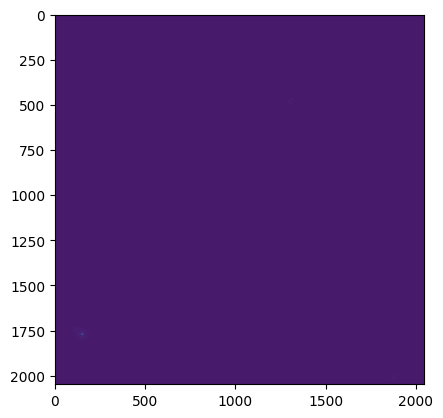

In [40]:
plt.imshow(reshaped_im)

Yeah another nothing-like image